In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
# Load Jersey City Area Price
df = pd.read_csv('../pre_data/JerseyCity_price.csv')

In [4]:
data = df.set_index('date')
data.index = pd.DatetimeIndex(data.index)

In [5]:
data.head()

,price
date,
2010-11-01,1787.0
2010-12-01,1812.0
2011-01-01,1822.0
2011-02-01,1827.0
2011-03-01,1846.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 99 entries, 2010-11-01 to 2019-01-01
Data columns (total 1 columns):
price    99 non-null float64
dtypes: float64(1)
memory usage: 1.5 KB


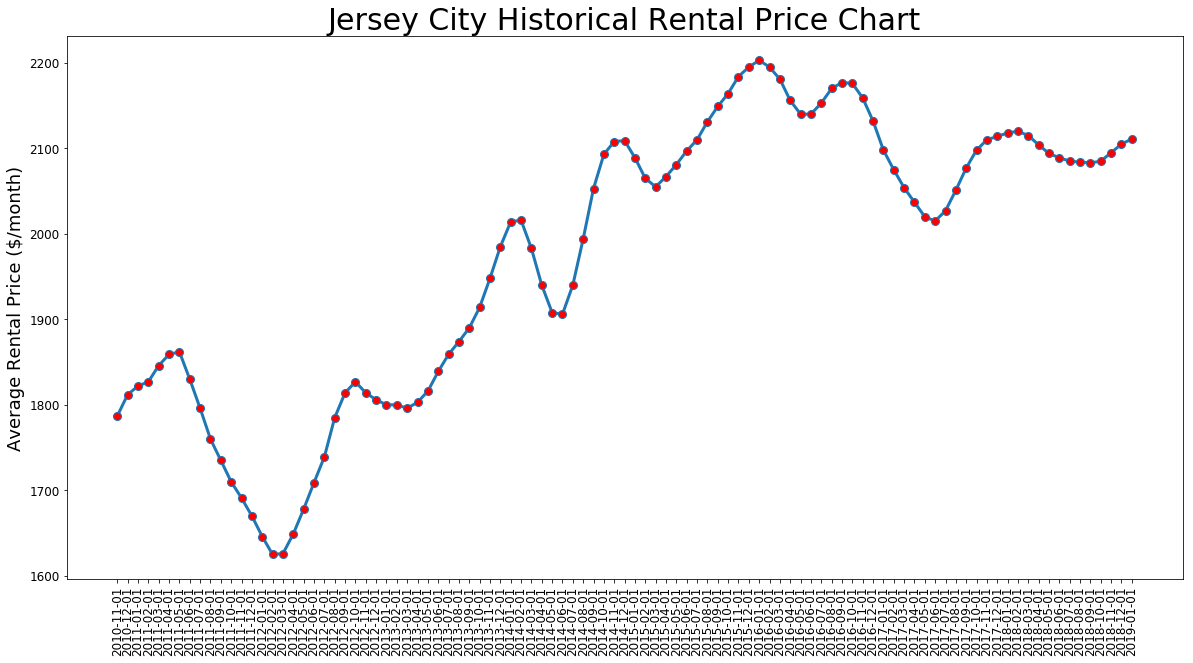

In [7]:
# Check the history data
m = df['date']
n = df['price']
plt.figure(figsize = (20, 10))
plt.plot(m, n, linewidth = 3, marker = 'o', markerfacecolor='red', markersize=8)
plt.title('Jersey City Historical Rental Price Chart', fontsize = 30)
plt.ylabel('Average Rental Price ($/month)', fontsize = 18)
plt.tick_params(labelsize = 12)
plt.xticks(rotation = 90)
# for i, j in zip(m, n):
#     plt.text(i, j + 2, j, ha = 'center', va = 'bottom', fontsize = 10)
plt.show()

In [7]:
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# # split data into train and test
# X = data.values
# train, test = X[0:-20], X[-20:]

# # walk-forward validation
# history = [x for x in train]
# predictions = list()

# for i in range(len(test)):
#     # make prediction
#     predictions.append(history[-1])
#     # observation
#     history.append(test[i])
    
# # report performance
# rmse = sqrt(mean_squared_error(test, predictions))
# print('RMSE: %.3f' % rmse)

# # line plot of observed vs predicted
# plt.plot(test)
# plt.plot(predictions)
# plt.show()

In [8]:
# # Transform Time Series to Stationary
# print(data.head())
# print()

# def inverse_difference(history, yhat, interval=1):
#     return yhat + history['price'][-interval]

# # invert transform
# inverted = list()
# for i in range(len(differenced)):
#     value = inverse_difference(data, differenced[i], len(data)-i)
#     inverted.append(value)
# inverted = pd.Series(inverted)
# print(inverted.head())
# print()

# # Create a differenced series
# def difference(dataset, interval=1):
#     diff = list()
#     for i in range(interval, len(dataset)):
#         value = dataset[i] - dataset[i - interval]
#         diff.append(value)
#     return pd.Series(diff)

# # transform to be stationary
# differenced = difference(data,1)
# print(differenced.head())

In [9]:
# # Transform Time Series to Scale
# from sklearn.preprocessing import MinMaxScaler

# print(data.head())
# print()

# # transform scale
# X = X.reshape(len(X), 1)
# scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = scaler.fit(X)
# scaled_X = scaler.transform(X)
# scaled_series = pd.Series(scaled_X[:, 0])
# print(scaled_series.head())
# print()

# # invert transform
# inverted_X = scaler.inverse_transform(scaled_X)
# inverted_series = pd.Series(inverted_X[:, 0])
# print(inverted_series.head())

## LSTM model - Long Short-Term Memory model

In [8]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# transform to supervised learning
supervised = timeseries_to_supervised(data, 1)
print(supervised.head())

             price   price
date                      
2010-11-01     0.0  1787.0
2010-12-01  1787.0  1812.0
2011-01-01  1812.0  1822.0
2011-02-01  1822.0  1827.0
2011-03-01  1827.0  1846.0


In [9]:
# Create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [10]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [11]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [12]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [13]:
# fit an LSTM network to training data
from keras.layers import LSTM

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.reset_states()
    return model

Using TensorFlow backend.


In [14]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [15]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

# transform data to be stationary
raw_values = data.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-20], supervised_values[-20:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
predict = lstm_model.predict(train_reshaped, batch_size=1)

Instructions for updating:
Colocations handled automatically by placer.


Month=1, Predicted=2027.412510, Expected=2015.000000
Month=2, Predicted=2022.369769, Expected=2027.000000
Month=3, Predicted=2034.902281, Expected=2051.000000
Month=4, Predicted=2059.572049, Expected=2077.000000
Month=5, Predicted=2086.009541, Expected=2098.000000
Month=6, Predicted=2107.117947, Expected=2110.000000
Month=7, Predicted=2118.895719, Expected=2114.000000
Month=8, Predicted=2122.469041, Expected=2118.000000
Month=9, Predicted=2126.163825, Expected=2120.000000
Month=10, Predicted=2127.895332, Expected=2115.000000
Month=11, Predicted=2122.489233, Expected=2104.000000
Month=12, Predicted=2111.035529, Expected=2094.000000
Month=13, Predicted=2100.805790, Expected=2089.000000
Month=14, Predicted=2095.860662, Expected=2085.000000
Month=15, Predicted=2091.943764, Expected=2084.000000
Month=16, Predicted=2091.126267, Expected=2083.000000
Month=17, Predicted=2090.254691, Expected=2085.000000
Month=18, Predicted=2092.455329, Expected=2095.000000
Month=19, Predicted=2102.852540, Expe

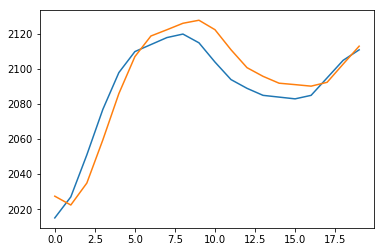

In [17]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-20:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(raw_values[-20:])
plt.plot(predictions)
plt.show()

1) Test RMSE: 13.756
2) Test RMSE: 13.178
3) Test RMSE: 11.916
4) Test RMSE: 10.933
5) Test RMSE: 11.571
6) Test RMSE: 10.188
7) Test RMSE: 12.886
8) Test RMSE: 11.551
9) Test RMSE: 15.949
10) Test RMSE: 10.415
11) Test RMSE: 11.964
12) Test RMSE: 10.094
13) Test RMSE: 14.983
14) Test RMSE: 10.528
15) Test RMSE: 11.814
16) Test RMSE: 10.024
17) Test RMSE: 10.940
18) Test RMSE: 14.269
19) Test RMSE: 11.209
20) Test RMSE: 12.413
21) Test RMSE: 10.011
22) Test RMSE: 9.064
23) Test RMSE: 11.444
24) Test RMSE: 11.717
25) Test RMSE: 10.522
26) Test RMSE: 11.533
27) Test RMSE: 10.084
28) Test RMSE: 10.757
29) Test RMSE: 14.673
30) Test RMSE: 10.349
            rmse
count  30.000000
mean   11.691099
std     1.676189
min     9.063607
25%    10.441560
50%    11.488460
75%    12.300638
max    15.948800


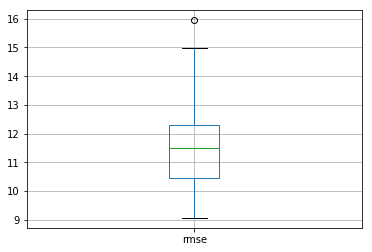

In [18]:
# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-20:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

# summarize results
results = pd.DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
plt.show()

In [19]:
# Build model

# transform data to be stationary
raw_values = data.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# transform the scale of the data
# fit scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(supervised_values)
# transform data
data_scaled = scaler.transform(supervised_values)

# fit the model
out_lstm_model = fit_lstm(data_scaled, 1, 3000, 4)

In [20]:
def prediction(step):
    result = list()
    for i in range(step):
        # make one-step forecast
        X, y = data_scaled[i, 0:-1], data_scaled[i, -1]
        yhat = forecast_lstm(out_lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, step+1-i)
        # store forecast
        result.append(yhat[0])
    return np.array(result)

In [47]:
# Get forecast 26 steps ahead in future
pred_long = prediction(step=26)
d = np.ones(26)*49
pred_long = pred_long - d
time_long = pd.date_range('20190201', periods=26, freq='MS')
pred_long_df = pd.DataFrame(np.round(pred_long,1), index = time_long, columns=['price'])
result_long = pd.concat([data, pred_long_df], axis=0)
result_long = result_long.reset_index()

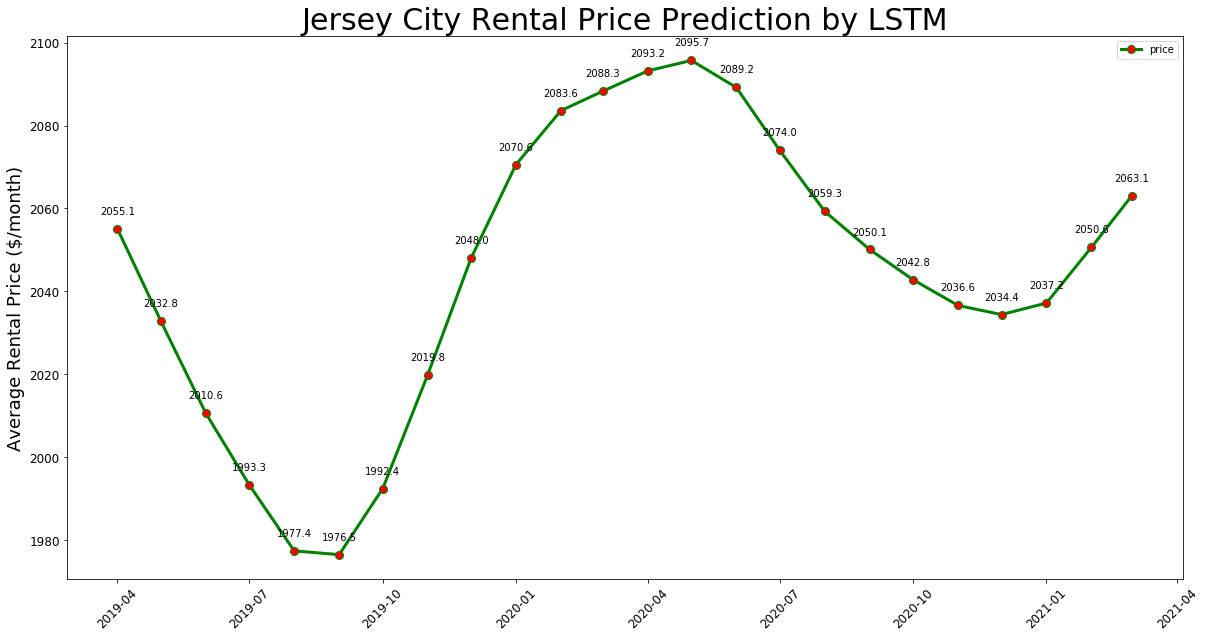

In [48]:
x2 = result_long['index'].tail(24)
y2 = result_long['price'].tail(24)

fig2 = plt.figure(figsize = (20, 10))
plt.plot(x2, y2, linewidth = 3, color='green', marker = 'o', markerfacecolor='red', markersize=8)

plt.title('Jersey City Rental Price Prediction by LSTM', fontsize = 30)
plt.ylabel('Average Rental Price ($/month)', fontsize = 18)
plt.tick_params(labelsize = 12)
plt.xticks(rotation = 45)
for i, j in zip(x2, y2):
    plt.text(i, j + 3, j, ha = 'center', va = 'bottom', fontsize = 10)
    
plt.legend()
plt.show()

In [50]:
fig2.savefig("../area_predict_pics/JerseyCity_long.jpg")

In [51]:
result_long.to_csv('JerseyCity_result_long.csv', index=False)

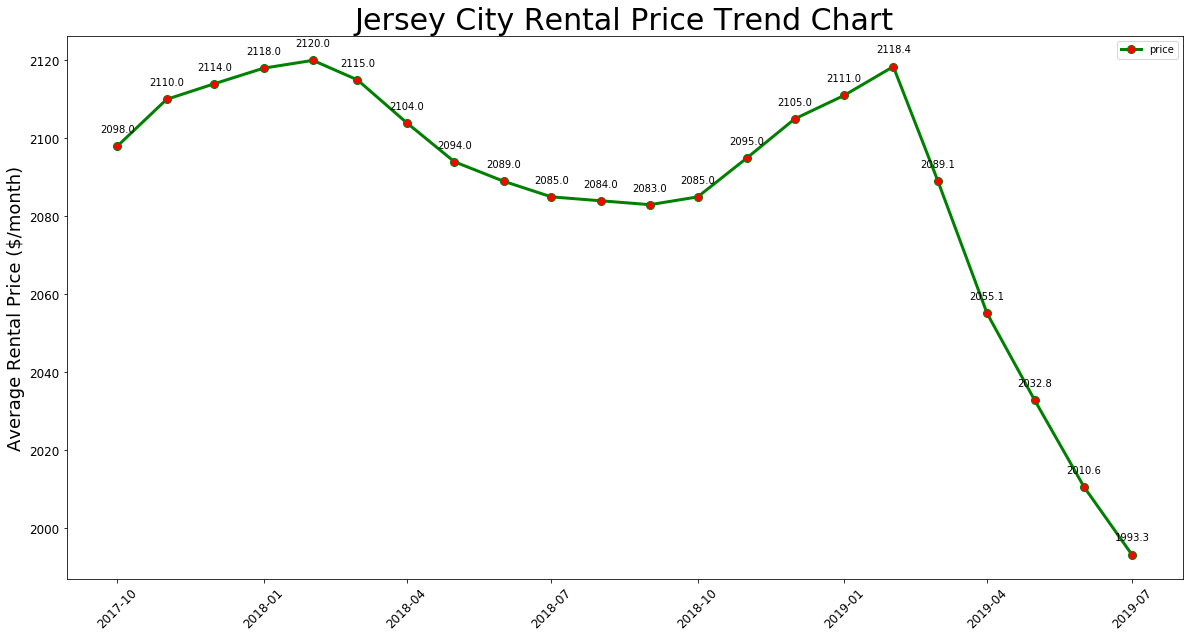

In [49]:
x = result_long['index'][-42: -20]
y = result_long['price'][-42: -20]

fig1 = plt.figure(figsize = (20, 10))
plt.plot(x, y, linewidth = 3, color='green', marker = 'o', markerfacecolor='red', markersize=8)

plt.title('Jersey City Rental Price Trend Chart', fontsize = 30)
plt.ylabel('Average Rental Price ($/month)', fontsize = 18)
plt.tick_params(labelsize = 12)
plt.xticks(rotation = 45)
for i, j in zip(x, y):
    plt.text(i, j + 3, j, ha = 'center', va = 'bottom', fontsize = 10)
    
plt.legend()
plt.show()

In [52]:
fig1.savefig("../area_predict_pics/JerseyCity.jpg")

## ARIMA model - AutoRegressive Integrated Moving Average model

In [53]:
# Select the best diff (Integrated)
from statsmodels.tsa.stattools import adfuller as ADF

print(ADF(data['price']))

(-1.1324933255743062, 0.7019415749167719, 8, 90, {'1%': -3.505190196159122, '5%': -2.894232085048011, '10%': -2.5842101234567902}, 597.9698042631078)


In [54]:
diff_1 = data.diff(1)
diff_1 = diff_1.dropna()
diff_1.columns = ['price_integrated']
print(ADF(diff_1['price_integrated']))

(-3.844063303723185, 0.0024873320018663314, 7, 90, {'1%': -3.505190196159122, '5%': -2.894232085048011, '10%': -2.5842101234567902}, 590.0828910745347)


In [55]:
# diff_2 = diff_1.diff(1)
# diff_2 = diff_2.dropna()
# diff_2.columns = ['price_integrated']
# print(ADF(diff_2['price_integrated']))

In [56]:
from statsmodels.stats.diagnostic import acorr_ljungbox

noiseRes = acorr_ljungbox(diff_1, lags=1)
print(noiseRes)

(array([68.34904046]), array([1.36971879e-16]))


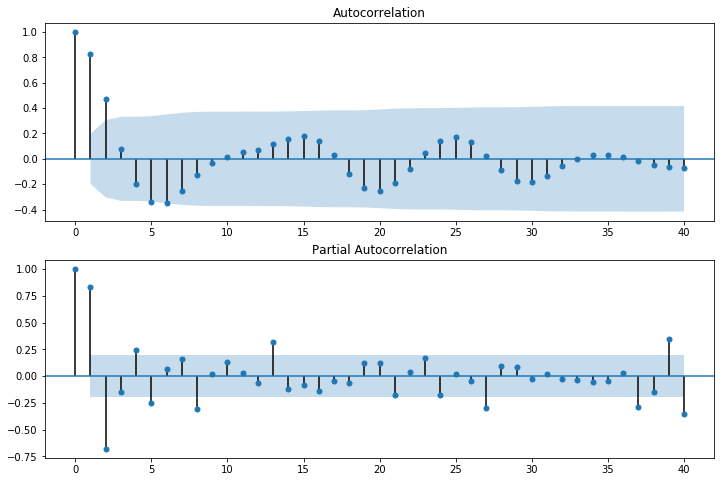

In [57]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_1,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_1,lags=40,ax=ax2)

In [58]:
# Select the best AR(p) and MA(q)
arma_mod20 = sm.tsa.ARMA(diff_1,(10,0),freq='MS').fit()
print(arma_mod20.aic,arma_mod20.bic,arma_mod20.hqic)
arma_mod30 = sm.tsa.ARMA(diff_1,(0,1),freq='MS').fit()
print(arma_mod30.aic,arma_mod30.bic,arma_mod30.hqic)
arma_mod40 = sm.tsa.ARMA(diff_1,(10,1),freq='MS').fit()
print(arma_mod40.aic,arma_mod40.bic,arma_mod40.hqic)
arma_mod50 = sm.tsa.ARMA(diff_1,(9,0),freq='MS').fit()
print(arma_mod50.aic,arma_mod50.bic,arma_mod50.hqic)
arma_mod60 = sm.tsa.ARMA(diff_1,(9,1),freq='MS').fit()
print(arma_mod60.aic,arma_mod60.bic,arma_mod60.hqic)

700.8092592864829 731.8288690305297 713.356051591277
799.4470643382801 807.2019667742918 802.5837624144787
702.7634280225943 736.3680052453118 716.355786352788
699.0534425649244 727.4880848303006 710.5546688443189
699.8084261762948 730.8280359203417 712.355218481089


In [59]:
p,q = 9,0

In [60]:
from statsmodels.tsa.arima_model import ARIMA

# Build ARIMA(9,1,0) model
model = ARIMA(data, (p,1,q), freq='MS')
arima_result = model.fit()

In [61]:
# Get forecast 27 steps ahead in future
pred = arima_result.forecast(steps=27)
time = pd.date_range('20190201', periods=27, freq='MS')
pred_df = pd.DataFrame(np.round(pred[0],1), index = time, columns=['price'])
output = pd.concat([data, pred_df], axis=0)
output = output.reset_index()

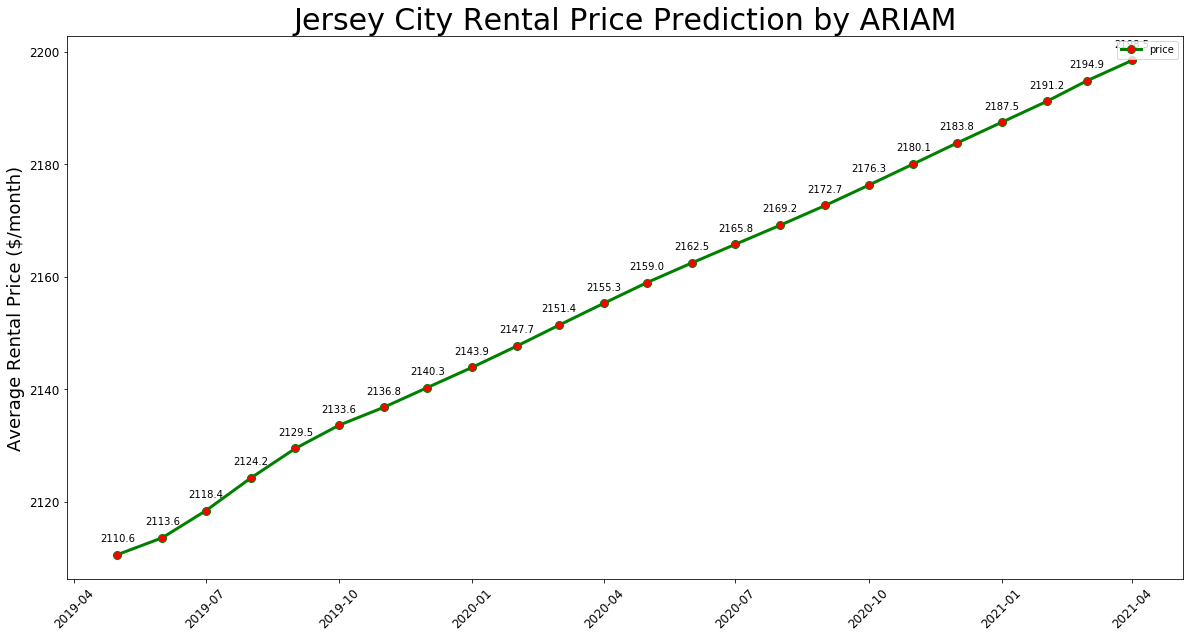

In [62]:
x3 = output['index'].tail(24)
y3 = output['price'].tail(24)

plt.figure(figsize = (20, 10))
plt.plot(x3, y3, linewidth = 3, color='green', marker = 'o', markerfacecolor='red', markersize=8)

plt.title('Jersey City Rental Price Prediction by ARIAM', fontsize = 30)
plt.ylabel('Average Rental Price ($/month)', fontsize = 18)
plt.tick_params(labelsize = 12)
plt.xticks(rotation = 45)
for i, j in zip(x3, y3):
    plt.text(i, j + 2, j, ha = 'center', va = 'bottom', fontsize = 10)
    
plt.legend()
plt.show()

In [63]:
arima_result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 727.4881  
Dependent Variable: D.price          Log-Likelihood:      -338.53   
Date:               2019-04-02 16:09 Scale:               1.0000    
No. Observations:   98               Method:              css-mle   
Df Model:           10               Sample:              12-01-2010
Df Residuals:       88                                    01-01-2019
Converged:          1.0000           S.D. of innovations: 7.497     
No. Iterations:     21.0000          HQIC:                710.555   
AIC:                699.0534                                        
---------------------------------------------------------------------
                  Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const             3.6457    2.5905   1.4073  0.1628  -1.4315   8.7229
ar.L1.D.price     1.5035    0.1019  14.7494  0.0000   1.3037   1.7033
ar.L2.D.price    -0.5881    0.1792  -3.2822  0.0015  -0.9393  -0.2369
ar.L3.D.price    -0.7471    0.1825  -4.0931  0.0001  -1.1048  -0.3894
ar.L4.D.price     1.0986    0.2017   5.4478  0.0000   0.7033   1.4938
ar.L5.D.price    -0.6053    0.2200  -2.7507  0.0072  -1.0365  -0.1740
ar.L6.D.price    -0.1964    0.2041  -0.9622  0.3386  -0.5964   0.2036
ar.L7.D.price     0.5358    0.1984   2.7011  0.0083   0.1470   0.9246
ar.L8.D.price    -0.3523    0.1944  -1.8122  0.0734  -0.7333   0.0287
ar.L9.D.price     0.0551    0.1075   0.5127  0.6094  -0.1555   0.2657
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1           -1.1180            -0.3137           1.1612            -0.4565
AR.2           -1.1180             0.3137           1.1612             0.4565
AR.3            0.1327            -1.2204           1.2276            -0.2328
AR.4            0.1327             1.2204           1.2276             0.2328
AR.5            0.8612            -0.8491           1.2094            -0.1239
AR.6            0.8612             0.8491           1.2094             0.1239
AR.7            1.0797            -0.4433           1.1672            -0.0620
AR.8            1.0797             0.4433           1.1672             0.0620
AR.9            4.4827            -0.0000           4.4827            -0.0000
====================================================================

"""